In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
import os
from torchvision import transforms
import torch
from PIL import Image
from torchvision.transforms import functional as F
import numpy as np
from PIL import Image
from scipy.ndimage import binary_dilation
from skimage.morphology import disk
import pandas as pd

In [ ]:
class ApplyLungMask:
    def __init__(self, left_rle, right_rle, margin_radius=30, original_shape=(1024, 1024), image_shape=(512, 512)):
        self.left_rle = left_rle
        self.right_rle = right_rle
        self.margin_radius = margin_radius
        self.original_shape = original_shape
        self.image_shape = image_shape

    def decode_rle(self, rle_str):
        if isinstance(rle_str, pd.Series):
            rle_str = rle_str.iloc[0]  
        if pd.isna(rle_str):
            return np.zeros(self.original_shape, dtype=np.uint8)
        
        s = list(map(int, rle_str.strip().split()))
        starts, lengths = s[0::2], s[1::2]
        flat_mask = np.zeros(self.original_shape[0] * self.original_shape[1], dtype=np.uint8)
        for start, length in zip(starts, lengths):
            flat_mask[start:start + length] = 1
        return flat_mask.reshape(self.original_shape)


    def dilate_mask(self, mask):
        selem = disk(self.margin_radius)
        return binary_dilation(mask, structure=selem).astype(np.uint8)

    def resize_mask(self, mask):
        mask_img = Image.fromarray(mask.astype(np.uint8) * 255)
        mask_resized = mask_img.resize((self.image_shape[1], self.image_shape[0]), resample=Image.NEAREST)
        return np.array(mask_resized) // 255

    def __call__(self, image):
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)

        image_resized = image.resize(self.image_shape[::-1], Image.BILINEAR)
        image_np = np.array(image_resized)

        left_mask = self.decode_rle(self.left_rle)
        right_mask = self.decode_rle(self.right_rle)

        left_mask = self.dilate_mask(left_mask)
        right_mask = self.dilate_mask(right_mask)

        combined_mask = np.clip(left_mask + right_mask, 0, 1)
        combined_mask = self.resize_mask(combined_mask)

        masked_image = image_np * combined_mask

        return Image.fromarray(masked_image.astype(np.uint8))

In [2]:
data = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\main\mimic\dataset\testing_clean_dataset.csv")

In [7]:
labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
data[labels]

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3462,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3463,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3464,0,0,0,0,0,0,0,0,0,0,0,0,0,0


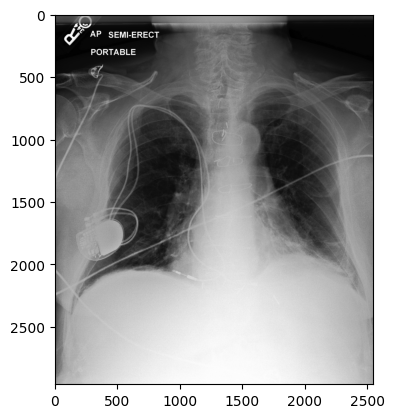

In [57]:
row = data.iloc[-1]
path = '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/'+ str(row['file_path'])
image = Image.open(path).convert('L')
plt.imshow(image,cmap='gray')
plt.show()
left_rle = row['Left Lung']
right_rle = row['Right Lung']
masker = ApplyLungMask(left_rle, right_rle, margin_radius=50)
image = masker(image)

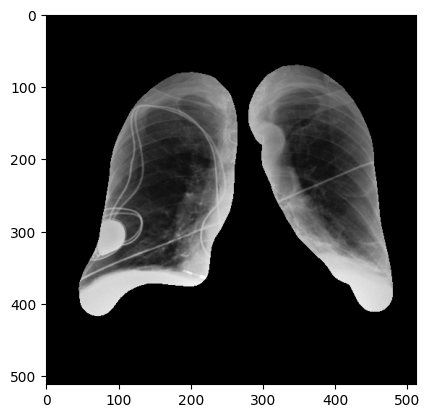

In [58]:
plt.imshow(image, cmap='gray')
plt.show()

In [35]:
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5062], std=[0.2873]),
    transforms.RandomResizedCrop(
        (200, 200),
        scale=(0.9, 1.0),               
        ratio=(0.9, 1.1),              
        interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(degrees=10)
    ])


In [36]:
trans_img = transform(image)

In [37]:
trans_img.shape

torch.Size([1, 200, 200])

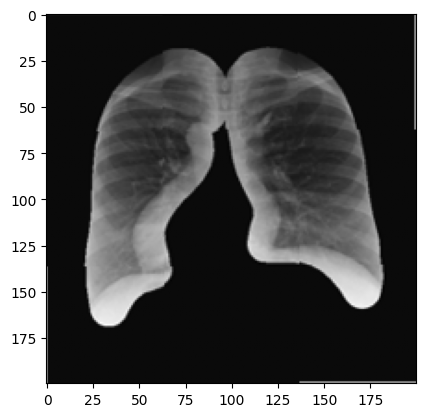

In [38]:
plt.imshow(trans_img.reshape(200,-1), cmap='gray')
plt.show()

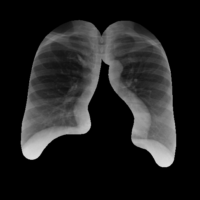

In [46]:
(image.resize([200,200],Image.BILINEAR))

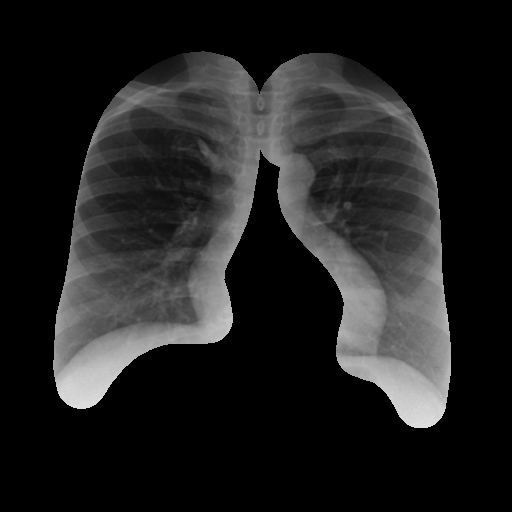

In [ ]:
image.

In [50]:
# Mean Squared Error (MSE)
mse = np.mean((torch.tensor(image) - trans_img ** 2))
print(f"MSE: {mse:.4f}")

# Peak Signal-to-Noise Ratio (PSNR)
if mse == 0:
    psnr = float('inf')
else:
    max_pixel = 255.0 if image.dtype == np.uint8 else 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

print(f"PSNR: {psnr:.2f} dB")


RuntimeError: Could not infer dtype of Image

In [6]:
paths = []
data = []
with open('//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/IMAGE_FILENAMES.txt', 'r') as f:
         paths = f.readlines()
for path in paths:
         p = path[:-1]
         path = p.split('/')
         patient_id = path[2][1:]
         study_id = path[3][1:]
         dicom_id = path[4].rstrip(".jpg")
         data.append((patient_id, study_id, dicom_id, p))

df_paths = pd.DataFrame(data, columns=['subject_id', 'study_id', 'dicom_id', 'file_path'])

In [7]:
df_paths

,subject_id,study_id,dicom_id,file_path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...
...,...,...,...,...
377105,19999733,57132437,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,files/p19/p19999733/s57132437/428e2c18-5721d8f...
377106,19999733,57132437,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,files/p19/p19999733/s57132437/58c403aa-35ff8bd...
377107,19999987,55368167,58766883-376a15ce-3b323a28-6af950a0-16b793bd,files/p19/p19999987/s55368167/58766883-376a15c...
377108,19999987,58621812,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,files/p19/p19999987/s58621812/7ba273af-3d290f8...


In [25]:
data = []
for path in paths:
     path = path.split('/')
     patient_id = path[2][1:]
     study_id = path[3][1:]
     data.append([patient_id, study_id])

In [ ]:
for path in paths:
     path = path.split('/')
     patient_id = path[2]
     study_id = path[3]
     print(, study_id.to(np.int16))
     break

AttributeError: 'str' object has no attribute 'to'

In [27]:
df_paths = pd.DataFrame(data, columns=['subject_id', 'study_id'])

In [31]:
df_paths['study_id'].astype('int32')

0         50414267
1         50414267
2         53189527
3         53189527
4         53911762
            ...   
377105    57132437
377106    57132437
377107    55368167
377108    58621812
377109    58971208
Name: study_id, Length: 377110, dtype: int32

In [11]:
df_paths['subject_id'].astype(str)

0         10000032
1         10000032
2         10000032
3         10000032
4         10000032
            ...   
377105    19999733
377106    19999733
377107    19999987
377108    19999987
377109    19999987
Name: subject_id, Length: 377110, dtype: object

In [17]:
data = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\main\mimic\dataset\testing_clean_dataset.csv")

In [28]:
t_data = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\main\mimic\dataset\train_clean_dataset.csv")

In [32]:
mask_mimic_jpg = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\main\mimic\dataset\MASK-MIMIC-CXR-JPG.csv")

In [33]:
metadata_mimic_jpg = pd.read_csv(r"\\gaia\imageData\public\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg\2.1.0\mimic-cxr-2.0.0-metadata.csv.gz")

In [35]:
mask_mimic_jpg['dicom_id'].isin(metadata_mimic_jpg['dicom_id']).sum()

np.int64(243334)

In [38]:
metadata_mimic_jpg['dicom_id'].isin(mask_mimic_jpg['dicom_id']).sum()

np.int64(243334)

In [29]:
merge = pd.concat([data['file_path'], t_data['file_path']], axis=0)

In [30]:
merge

0        files/p12/p12164298/s57720540/113162cd-9bf5355...
1        files/p14/p14086236/s52901222/2321df8e-a210e88...
2        files/p14/p14732249/s57763057/33acb052-7b4db2f...
3        files/p14/p14448385/s52158934/687e5c6b-9ab7327...
4        files/p10/p10823672/s53940327/ba53dbc4-90c594c...
                               ...                        
31196    files/p14/p14884724/s52656651/3573f686-9ab72d2...
31197    files/p11/p11849839/s55325419/d9e0cf64-56e19d8...
31198    files/p13/p13280884/s54942402/07a9258e-7b410c6...
31199    files/p10/p10258162/s55178181/5664daed-62b42b8...
31200    files/p14/p14578738/s51404397/fb0b6215-aba0e8e...
Name: file_path, Length: 34668, dtype: object

In [31]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import os
import numpy as np

# Define your data transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a standard size (e.g., 224x224)
    transforms.ToTensor(),          # Convert image to a PyTorch tensor
])

# Path to your MIMIC-CXR-JPG dataset
dataset_dir = '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/'

# Collect all the image file paths
image_paths = [os.path.join(dataset_dir, fname) for fname in merge if fname.endswith('.jpg')]

# Initialize lists to collect pixel values
all_pixels = []

# Load images and collect pixel data
for img_path in image_paths:
    img = Image.open(img_path).convert('L')
    img = transform(img)  # Apply the transformations
    all_pixels.append(img)

# Convert all collected pixel data into a single tensor
all_pixels = torch.stack(all_pixels)

# Compute the mean and std
mean = torch.mean(all_pixels, dim=(0, 2, 3))  # Mean across batch, height, and width
std = torch.std(all_pixels, dim=(0, 2, 3))    # Std across batch, height, and width

print("Mean:", mean)
print("Standard Deviation:", std)


KeyboardInterrupt: 

In [18]:
data

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,Pleural Other,Pneumonia,Pneumothorax,Support Devices,race,file_path,dicom_id,Left Lung,Right Lung,Landmarks
0,12164298,57720540,0,1,0,0,0,0,0,0,...,0,0,0,0,WHITE,files/p12/p12164298/s57720540/113162cd-9bf5355...,113162cd-9bf5355f-13bad6ea-07690f7f-7a478732,208518 9 209539 26 210561 36 211582 42 212603 ...,193966 7 194980 21 195994 34 197011 44 198033 ...,"434,189,403,192,370,206,336,227,306,253,282,28..."
1,14086236,52901222,0,1,0,0,0,0,0,0,...,0,0,0,0,WHITE,files/p14/p14086236/s52901222/2321df8e-a210e88...,2321df8e-a210e88c-52ef8427-db26d8c2-119a40e6,237173 9 238195 27 239217 38 240239 43 241261 ...,230732 17 231753 37 232773 45 233794 52 234815...,"362,226,332,225,302,234,274,250,252,269,232,29..."
2,14732249,57763057,1,1,0,0,0,0,0,0,...,0,0,0,1,WHITE,files/p14/p14732249/s57763057/33acb052-7b4db2f...,33acb052-7b4db2f0-5c7ebf09-67484400-2e83cbfc,247335 19 248357 39 249378 45 250400 50 251421...,242958 6 243977 19 244996 32 246016 43 247035 ...,"271,237,237,244,204,265,173,291,145,317,125,34..."
3,14448385,52158934,0,1,0,1,0,0,0,1,...,0,0,0,0,BLACK/AFRICAN AMERICAN,files/p14/p14448385/s52158934/687e5c6b-9ab7327...,687e5c6b-9ab73270-6eaabec1-37daf34d-6bfe4b9c,159371 32 160391 40 161412 46 162433 53 163453...,137607 9 138627 27 139647 39 140668 44 141688 ...,"419,136,391,134,358,143,326,158,299,178,276,20..."
4,10823672,53940327,0,0,0,0,0,0,0,0,...,0,0,0,0,WHITE,files/p10/p10823672/s53940327/ba53dbc4-90c594c...,ba53dbc4-90c594cb-dd32b867-0890e788-aa168157,206491 10 207499 31 208515 43 209537 50 210559...,188828 7 189841 22 190854 37 191872 47 192894 ...,"416,184,383,187,349,204,317,227,288,256,266,28..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,16287674,50729997,0,0,0,0,0,0,0,0,...,1,0,0,0,WHITE,files/p16/p16287674/s50729997/0407be47-46a4a3d...,0407be47-46a4a3d1-25eeab50-2d5d7d96-4bc3e940,147038 7 148056 19 149074 31 150091 44 151109 ...,142709 10 143715 31 144728 46 145750 51 146772...,"380,139,344,141,307,158,268,181,233,211,202,24..."
3463,18844027,55021519,0,1,1,0,0,0,0,0,...,0,0,1,1,WHITE,files/p18/p18844027/s55021519/d3d53acd-3d8a03c...,d3d53acd-3d8a03c9-04a23048-1e3bf668-9d1ed390,182946 10 183968 31 184990 44 186012 49 187034...,179624 5 180640 16 181656 28 182672 39 183688 ...,"426,175,387,180,347,200,308,229,276,266,253,30..."
3464,10005858,58425702,0,0,0,0,0,0,0,0,...,0,0,0,0,WHITE,files/p10/p10005858/s58425702/fd95fcb1-d91fbd9...,fd95fcb1-d91fbd94-9b980db7-616ee57b-cb02e6ae,195182 10 196204 29 197225 42 198246 49 199268...,195947 6 196963 18 197979 30 198995 42 200014 ...,"366,191,333,195,306,213,280,236,256,262,236,29..."
3465,14889442,51360855,0,0,0,0,0,0,0,0,...,0,0,0,0,WHITE,files/p14/p14889442/s51360855/18a99b48-92c65ae...,18a99b48-92c65ae1-5884f1a3-9da1b764-3d6338c6,160331 7 161346 20 162361 34 163380 43 164402 ...,161125 5 162143 15 163162 24 164181 33 165199 ...,"358,157,331,162,301,178,271,201,245,228,224,25..."


In [ ]:
import pandas as pd

chunksize = 10000
all_mask_data = []

file_path = r"\\gaia\imageData\deep_learning\input\data\chexmask\chexmask-database-a-large-scale-dataset-of-anatomical-segmentation-masks-for-chest-x-ray-images-1.0.0\Preprocessed\MIMIC-CXR-JPG.csv"

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    all_mask_data.extend(chunk[['dicom_id', 'Left Lung', 'Right Lung', 'Landmarks']].to_dict('records'))


In [ ]:
mask_df = pd.DataFrame(all_mask_data)

In [3]:
file_path = r"\\gaia\imageData\deep_learning\input\data\chexmask\chexmask-database-a-large-scale-dataset-of-anatomical-segmentation-masks-for-chest-x-ray-images-1.0.0\Preprocessed\MIMIC-CXR-JPG.csv"
chunksize = 1000
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    mask_data = chunk
    break


In [4]:
mask_data['Landmarks']

0      412,138,392,141,369,157,342,179,317,202,296,23...
1      457,62,418,65,380,80,342,103,313,131,291,164,2...
2      397,143,375,146,352,163,327,187,302,211,280,24...
3      372,169,350,168,326,186,301,212,281,239,267,27...
4      380,161,353,165,326,185,298,210,273,238,251,26...
                             ...                        
995    295,209,268,211,240,225,212,242,188,261,167,28...
996    371,193,337,197,303,213,270,234,241,257,217,28...
997    422,224,385,226,346,242,306,261,271,280,240,30...
998    320,240,293,245,266,260,241,277,221,294,204,31...
999    303,218,272,222,240,238,209,257,184,277,162,30...
Name: Landmarks, Length: 1000, dtype: object

In [5]:
data['file_path'].str.split('/')

NameError: name 'data' is not defined

In [6]:
dicom_id = []
for path in data['file_path'].str.split('/'):
     dicom_id.append(path[-1][:-4])

NameError: name 'data' is not defined

In [7]:
dicom_df = pd.DataFrame(dicom_id)

In [8]:
new_data = pd.concat([data, dicom_df], axis=1)

NameError: name 'data' is not defined

In [9]:
new_data.rename(columns={0:'dicom_id'}, inplace=True)

NameError: name 'new_data' is not defined

In [10]:
mask_df

NameError: name 'mask_df' is not defined

In [11]:
mask_dicom_id = mask_df[mask_df['dicom_id'].isin(dicom_id)]['dicom_id']

NameError: name 'mask_df' is not defined

In [12]:
mask_contain_datset = new_data[new_data['dicom_id'].isin(mask_dicom_id)]

NameError: name 'new_data' is not defined

In [ ]:
merge_mask_dataset = pd.merge(mask_contain_datset, mask_df, how='inner', on='dicom_id')

In [ ]:
merge_mask_dataset.columns

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices', 'race',
       'file_path', 'dicom_id', 'Left Lung', 'Right Lung', 'Landmarks'],
      dtype='object')

(3056, 2544)


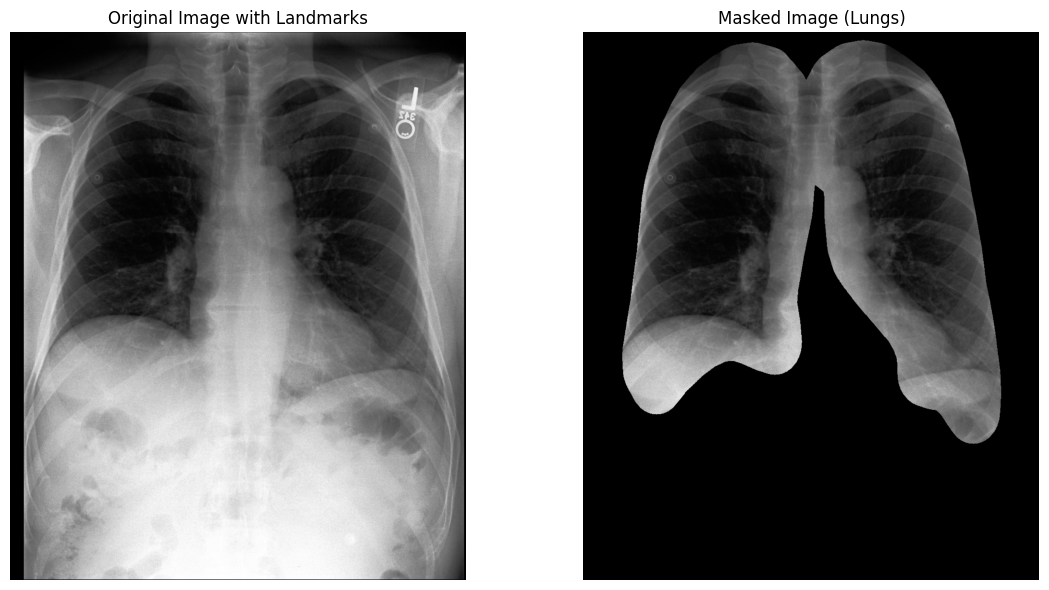

In [26]:

import cv2
import numpy as np
from scipy.ndimage import binary_dilation
from skimage.morphology import disk
import matplotlib.pyplot as plt
from PIL import Image

def decode_rle(rle_str, shape=(1024, 1024)):
    """
    Decode RLE string to binary mask.
    """
    s = list(map(int, rle_str.strip().split()))
    starts, lengths = s[0::2], s[1::2]
    flat_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        flat_mask[start:start + length] = 1
    return flat_mask.reshape(shape)


def dilate_mask(mask, margin_radius):
    selem = disk(margin_radius)
    return binary_dilation(mask, structure=selem).astype(np.uint8)

def resize_mask(mask, new_shape):
    """
    Resize mask using nearest neighbor (no interpolation).
    """
    mask_img = Image.fromarray(mask.astype(np.uint8) * 255)
    mask_resized = mask_img.resize((new_shape[1], new_shape[0]), resample=Image.NEAREST)
    return np.array(mask_resized) // 255  # back to binary


def rescale_landmarks(landmarks, from_shape, to_shape):
    """
    Rescale landmark coordinates from one image shape to another.
    """
    scale_x = to_shape[1] / from_shape[1]
    scale_y = to_shape[0] / from_shape[0]
    return [(int(x * scale_x), int(y * scale_y)) for x, y in landmarks]



def parse_landmarks(landmark_str):
    try:
        coords = list(map(int, landmark_str.strip().split(',')))
        if len(coords) % 2 != 0:
            raise ValueError("Uneven number of coordinates in landmark string")
        landmarks = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
        return landmarks
    except Exception as e:
        print("Failed to parse landmarks:", e)
        return []



mask_df = data
row = mask_df.iloc[11]

# === Step 3: Load image ===
image_path = '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/' + row['file_path']
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(image.shape)
h, w = image.shape
original_shape = (1024, 1024)
actual_shape = image.shape 

left_mask = decode_rle(row['Left Lung'], shape=(1024, 1024))
right_mask = decode_rle(row['Right Lung'], shape=(1024, 1024))

left_mask_dilated = dilate_mask(left_mask, 60)   # smaller margin
right_mask_dilated = dilate_mask(right_mask, 60) # bigger margin

mask_combined = np.clip(left_mask_dilated + right_mask_dilated, 0, 1)
mask_resized = resize_mask(mask_combined, image.shape)
masked_image = image * mask_resized

# Apply the mask to image
masked_image = image * mask_resized


# Plot everything
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image with Landmarks")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked Image (Lungs)")
plt.imshow(masked_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [81]:
import pandas as pd
import numpy as np
import copy
import os
import matplotlib.pyplot as plt
import cv2

In [166]:

from torch.utils.data import Dataset, DataLoader, random_split
import os
from torchvision import transforms
import torch
from PIL import Image
        
class MyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, base_dir='//gaia/imageData/deep_learning/output/Sutariya/chexpert/'):
        self.image_paths = list(image_paths)
        self.labels = labels
        self.transform = transform
        self.base_dir = base_dir

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = os.path.join(self.base_dir, self.image_paths[idx])
        image = Image.open(path)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32) 
        return image, label


def prepare_dataloaders(image_paths, labels, shuffle=False):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda i: i.repeat(3, 1, 1) if i.shape[0] == 1 else i),
        transforms.Lambda(lambda i: i/255),
        transforms.Normalize(mean=[0.5062, 0.5062, 0.5062], std=[0.2873, 0.2873, 0.2873]), # Adapt to own standard deviation and mean to Chexpert
        transforms.Lambda(lambda i: i.to(torch.float32)),
        transforms.RandomResizedCrop((224,224), scale=(0.6, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(contrast=(0.7, 1.2)) # Randomly change the brightness, contrast, saturation and hue of an image
    ])

    dataset = MyDataset(image_paths, labels, transform)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=shuffle, num_workers=4, pin_memory=True)

    return data_loader

In [198]:
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC), 
    transforms.ToTensor(),
    transforms.Lambda(lambda i: i.repeat(3, 1, 1) if i.shape[0] == 1 else i),
    transforms.Normalize(mean=[0.5062]*3, std=[0.2873]*3),
    transforms.RandomResizedCrop(
        (200, 200),
        scale=(0.9, 1.0),               
        ratio=(0.9, 1.1),              
        interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(degrees=10)
    ])

In [174]:
training_dataset_chexpert = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\chexpert\train_clean_dataset.csv") 

In [199]:
labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
data = MyDataset(training_dataset_chexpert['Path'], training_dataset_chexpert[labels].values, transform=transform)

In [200]:
data1 = MyDataset(training_dataset_chexpert['Path'], training_dataset_chexpert[labels].values)

In [225]:
img, lbl = data.__getitem__(666)

In [226]:
img1, lbl1 = data1.__getitem__(666)

In [230]:
img.shape

torch.Size([3, 200, 200])

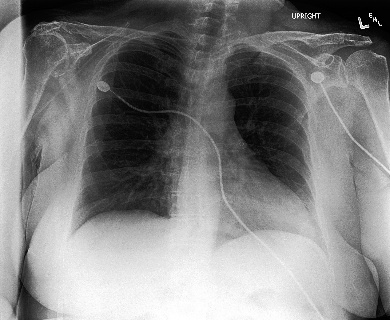

In [233]:
img1

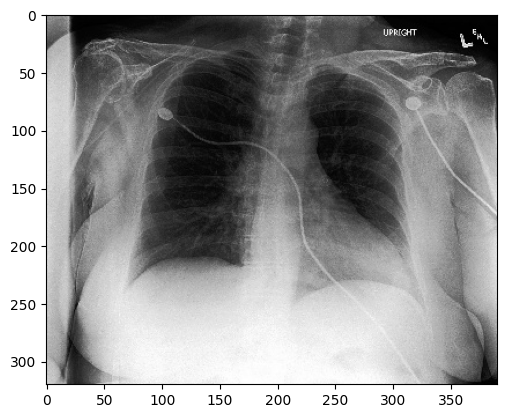

In [227]:
plt.imshow(img1, cmap='gray')
plt.show()

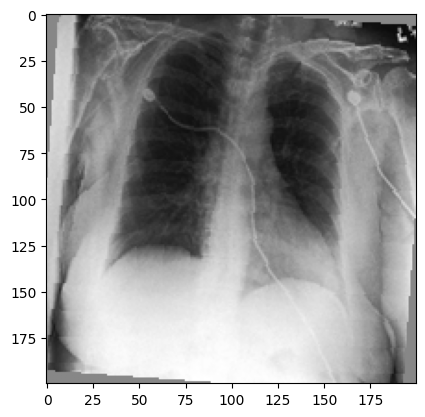

In [228]:
plt.imshow(img[0],cmap='gray')
plt.show()

In [21]:
img.shape

torch.Size([1, 320, 347])

In [8]:
data.labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])

In [56]:
for img, label in train_loader:
     print(img, label)
     break

: 

In [50]:
training_dataset_chexpert['Pneumonia']

0        0
1        0
2        0
3        0
4        0
        ..
56597    0
56598    0
56599    0
56600    0
56601    0
Name: Pneumonia, Length: 56602, dtype: int64

In [ ]:
print(path)

In [ ]:
valid = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\chexpert\valid.csv")

In [ ]:
def select_most_positive_sample(group):

    disease_columns = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture'
    ]
    
    group['positive_count'] = group[disease_columns].sum(axis=1)
    
    positive_cases = group[group['positive_count'] > 0]
    
    if not positive_cases.empty:

        selected_sample = positive_cases.loc[positive_cases['positive_count'].idxmax()]
    else:
        selected_sample = group.sample(n=1).iloc[0]
    
    return selected_sample


# Select the single subject_id per patient which has most positive disease 
def sampling_datasets(training_dataset):

    training_dataset = training_dataset.groupby('subject_id', group_keys=False).apply(select_most_positive_sample)
    training_dataset.drop(columns=['positive_count'], inplace=True, errors='ignore')
    
    return training_dataset


def cleaning_datasets(traning_dataset):

    traning_dataset[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']] = (traning_dataset[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']].fillna(0.0) == 1.0).astype(int)  # In The limits of fair medical imaging paper they treat uncertain label as negative and fill NA with 0.

    #Select only Frontal View 
    traning_dataset = traning_dataset[traning_dataset['Frontal/Lateral'] == 'Frontal']

    return traning_dataset


In [ ]:
def merge_dataframe(training_data, demographic_data):
    path = training_data['Path']
    patientid = []
    for i in path:
        id = i.split(sep='/')[2]
        id = id.replace("patient", "")
        patientid.append(float(id))

    temp_patient = pd.DataFrame(patientid,columns=['patient_id'])
    training_data = training_data.reset_index(drop=True)
    training_data['subject_id'] = temp_patient['patient_id']
    training_data_merge = training_data.merge(demographic_data, on='subject_id')
    return training_data_merge



In [ ]:
demo = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\chexpert\demographics_CXP.csv")

In [ ]:
merge_data = merge_dataframe(training_data, demo)

In [ ]:
clean_merge_data = cleaning_datasets(merge_data)

In [ ]:
sampling_merge_data = sampling_datasets(clean_merge_data)

In [ ]:
sampling_merge_data['']

In [ ]:
train_ethnic_group = sampling_merge_data.groupby('ethnicity')

In [ ]:
group_by_data = {}
for group, data in train_ethnic_group:
     group_by_data[group] = data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

N = 60 
ethnicity_col = 'Ethnicity'
diseases = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", 'Support Devices'
]
ethnic_groups = ["Non-Hispanic/Non-Latino", "Hispanic/Latino"]

df = sampling_merge_data

# Helper to sample for test set
def sample_test(df_group, disease, n_samples=N):
    positives = df_group[df_group[disease] == 1]

    sampled_pos = positives.sample(n=n_samples, random_state=42)

    return sampled_pos

# Sample the test set
test_dfs = []

for ethnicity in ethnic_groups:
    df_ethnicity = group_by_data[ethnicity]
    
    for disease in diseases:
        sampled_test = sample_test(df_ethnicity, disease, N)
        test_dfs.append(sampled_test)

# Combine test samples
final_test_df = pd.concat(test_dfs).drop_duplicates().reset_index(drop=True)


# Save
final_test_df.to_csv('test_split.csv', index=False)

print("✅ Done! Test shape:", final_test_df.shape)


In [ ]:
test = pd.read_csv('test_split.csv')

In [ ]:
"Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax"

In [ ]:
test['Support Devices'].value_counts()

In [ ]:
test.to_csv('test_split.csv', index=False)

In [ ]:
test = pd.read_csv('test_split.csv')

In [ ]:
test['No Finding'].value_counts().values

In [ ]:
sample = test[test['Fracture'] == 1].sample(20)

In [ ]:
sample

In [ ]:
test[test['Fracture'] == 0]

In [ ]:

test[test['Fracture'] == 0].sample(10)

In [ ]:
sampling_merge_data.columns

In [ ]:
test.drop(['Sampled_Ethnicity', 'Sampled_Disease'], axis=1, inplace=True)

In [ ]:
test.columns

In [ ]:
group_by_data = {}
group_data = test.groupby('ethnicity')
for g, d in group_data:
     group_by_data[g] = d

In [ ]:

features = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]

feature_counts = []

for feature in features:
    counts = group_by_data['Non-Hispanic/Non-Latino'][feature].value_counts()
    for value, count in counts.items():
        feature_counts.append({
            'Feature': feature,
            'Value': value,
            'Count': count,
            'ratio': np.round(count / len(group_by_data['Non-Hispanic/Non-Latino']),2)
        })

summary_non_hispanic_df = pd.DataFrame(feature_counts)

summary_non_hispanic_df = summary_non_hispanic_df.sort_values(by=['Feature', 'Count']).reset_index(drop=True)



In [ ]:
summary_non_hispanic_df

In [ ]:
sampling_dataset = pd.read_csv(r"E:\Thesis\CXR_Preprocessing\cxr_preprocessing\sampling_data_merge.csv")

In [ ]:
sampling_dataset

In [ ]:
test = pd.read_csv(r'E:\Thesis\CXR_Preprocessing\cxr_preprocessing\test_split.csv')

In [ ]:
test['subject_id'].value_counts()

In [ ]:
traning_data = sampling_dataset[~sampling_dataset['subject_id'].isin(test['subject_id'])]

In [ ]:
traning_data

In [ ]:
len(sampling_dataset) - len(traning_data)

In [ ]:


features = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]

feature_counts = []

for feature in features:
    counts = group_by_data['Hispanic/Latino'][feature].value_counts()
    for value, count in counts.items():
        feature_counts.append({
            'Feature': feature,
            'Value': value,
            'Count': count,
            'ratio': np.round(count / len(group_by_data['Hispanic/Latino']),2)
        })

summary_hispanic_df = pd.DataFrame(feature_counts)

summary_hispanic_df = summary_hispanic_df.sort_values(by=['Feature', 'Count']).reset_index(drop=True)



In [ ]:
summary_hispanic_df

In [ ]:
summary_non_hispanic_df

In [ ]:
group_by_data['Non-Hispanic/Non-Latino'].value_counts(subset=[
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture'
    ])

In [ ]:
training_data_merge = pd.read_csv(r"E:\Thesis\CXR_Preprocessing\sampling_data_merge.csv")

In [ ]:
random_numbers = np.random.randint(len(training_data_merge['Path']), size=10)

In [ ]:
imgs = []
for i in range(len(random_numbers)):
     img = cv2.imread(r'..//..//datasets/' + str(training_data_merge['Path'][random_numbers[i]]), cv2.IMREAD_GRAYSCALE)
     imgs.append(img)

In [ ]:

for i in imgs:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    adaptive_img = clahe.apply(i)
    
    images = [i ,adaptive_img]
    titles = ['Original Image',  'Adaptive Hist']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  

    for i, image in enumerate(images):
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(titles[i])
        axes[i, 0].axis('off')

        axes[i, 1].hist(image.ravel(), bins=256)
        axes[i, 1].set_title('Histogram')

        axes[i, 2].hist(image.ravel(), bins=256, cumulative=True)
        axes[i, 2].set_title('Cumulative Distribution')


plt.tight_layout()
plt.show()


In [ ]:

for i in imgs:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    adaptive_img = clahe.apply(i)


    images = [i ,adaptive_img]
    titles = ['Original Image',  'Adaptive Hist']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  

    for i, image in enumerate(images):
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(titles[i])
        axes[i, 0].axis('off')

        axes[i, 1].hist(image.ravel(), bins=256)
        axes[i, 1].set_title('Histogram')

        axes[i, 2].hist(image.ravel(), bins=256, cumulative=True)
        axes[i, 2].set_title('Cumulative Distribution')


plt.tight_layout()
plt.show()


In [ ]:
eq_hist_img

In [ ]:
eq_hist_img = cv2.equalizeHist(resized_img)

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
ada_hist_img = clahe.apply(resized_img)

In [ ]:

plt.figure(figsize=(15, 5))
# Plot original histogram and cumulative histogram
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(eq_hist_img, cmap='gray')


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(img.ravel(), bins=255, range=(1,255))


plt.subplot(1, 2, 2)
plt.hist(eq_hist_img.ravel()*255, bins=255,  range=(1,255))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(ada_hist_img.ravel()*255, bins=255,  range=(1,255))


plt.subplot(1, 2, 2)
plt.imshow(ada_hist_img, cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(img.ravel(), bins=256, cumulative=True)
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(ada_hist_img.ravel(), bins=256, cumulative=True)


plt.subplot(1, 2, 2)
plt.hist(eq_hist_img.ravel(), bins=256, cumulative=True)
plt.show()


In [ ]:
mimic_dataset = pd.read_csv('../../mimic_cxr/mimic_cxr_jpg_with_demographics.csv')

In [ ]:
mimic_dataset

In [ ]:
def cleaning_datasets(traning_dataset):

    traning_dataset[['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']] = (traning_dataset[['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']].fillna(0.0) == 1.0).astype(int) # In The limits of fair medical imaging paper they treat uncertain label as negative and fill NA with 0.

    return traning_dataset

In [ ]:
import pandas as pd

def select_most_positive_sample(group):
    disease_columns = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
        'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 
        'Lung Opacity', 'No Finding', 'Pleural Effusion', 
        'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
    ]
    
    # Count positive cases
    group['positive_count'] = group[disease_columns].sum(axis=1)

    # Select cases with at least one positive disease
    positive_cases = group[group['positive_count'] > 0]
    
    if not positive_cases.empty:
        selected_sample = positive_cases.loc[[positive_cases['positive_count'].idxmax()]].copy()
    else:
        selected_sample = group.sample(n=1)

    return selected_sample

# Select one subject_id per patient with the most positive diseases
def sampling_datasets(training_dataset):
    training_dataset = training_dataset.groupby('subject_id', group_keys=False).apply(select_most_positive_sample)
    
    # Drop helper column
    training_dataset.drop(columns=['positive_count'], inplace=True, errors='ignore')

    return training_dataset


In [ ]:
mimic_dataset = cleaning_datasets(mimic_dataset)

In [ ]:

sampling_mimic_dataset = sampling_datasets(mimic_dataset)

In [ ]:
sampling_mimic_dataset

In [ ]:
mimic_dataset.columns

In [ ]:
patient_id, study_id = sampling_mimic_dataset['subject_id'], sampling_mimic_dataset['study_id']

In [ ]:
paths = []
with open('IMAGE_FILENAMES.txt', 'r') as f:
     paths = f.readlines()

In [ ]:
paths[0][0:-1]

In [ ]:
paths[0][:-1]

In [ ]:
clean_path = []
for i in paths:
     clean_path.append(i[:-1])

In [ ]:
clean_path

In [ ]:
paths[0][0:-1][11:19]

In [ ]:
paths[0][0:-1][21:29]

In [ ]:

data = []
for path in clean_path:
    
    patient_id = path[11:19]
    study_id = path[21:29]
    data.append((patient_id, study_id, path))

df_paths = pd.DataFrame(data, columns=['subject_id', 'study_id', 'file_path'])




In [ ]:
df_paths

In [ ]:
df_paths['subject_id'] = df_paths['subject_id'].astype(str)
df_paths['study_id'] = df_paths['study_id'].astype(str)

# Ensure mimic_dataset has the same data types
sampling_mimic_dataset['subject_id'] = sampling_mimic_dataset['subject_id'].astype(str)
sampling_mimic_dataset['study_id'] = sampling_mimic_dataset['study_id'].astype(str)

In [ ]:
merge_mimic_dataset = sampling_mimic_dataset.merge(df_paths, on=['subject_id', 'study_id'], how='left')

In [ ]:
merge_mimic_dataset

In [ ]:
merge_mimic_dataset.drop_duplicates(subset=['subject_id', 'study_id'], inplace=True)


In [ ]:
img = '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0' + str(merge_mimic_dataset['file_path'][0])

In [ ]:
img

In [ ]:
plt.imread(img)

In [ ]:
img, img1, img2,img3 ,img4, img5,img6,img7,img8 = plt.imread(r"E:\Thesis\demo.jpg"),plt.imread(r"E:\Thesis\demo1.jpg"), plt.imread(r"E:\Thesis\demo (2).jpg"), plt.imread(r"E:\Thesis\demo (3).jpg"), plt.imread(r"E:\Thesis\demo (4).jpg"), plt.imread(r"E:\Thesis\demo (5).jpg"), plt.imread(r"E:\Thesis\demo (6).jpg"), plt.imread(r"E:\Thesis\demo (7).jpg"), plt.imread(r"E:\Thesis\demo (8).jpg")

In [ ]:
eq_img, eq_img1, eq_img2, eq_img3,eq_img4,eq_img5,eq_img6,eq_img7,eq_img8 = exposure.equalize_hist(img), exposure.equalize_hist(img1), exposure.equalize_hist(img2), exposure.equalize_hist(img3), exposure.equalize_hist(img4), exposure.equalize_hist(img5), exposure.equalize_hist(img6), exposure.equalize_hist(img7), exposure.equalize_hist(img8)

In [ ]:
images = [img, img1, img2, img3, img4, img5, img6, img7, img8]
equalized_images = [eq_img, eq_img1, eq_img2, eq_img3, eq_img4, eq_img5, eq_img6, eq_img7, eq_img8]


In [ ]:
def read_and_equalize(image_path):
    # Read image in grayscale
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to (224, 224)
    resized_img = cv2.resize(original_img, (224,224))
    
    # Exclude pixels with 0 value for processing
    img = resized_img[(resized_img > 0)]
    
    # Equalize the histogram of the image
    hist = exposure.equalize_hist(img,nbins=255)
    
    return resized_img, hist

# Paths for your 9 images
image_paths = [
    r"E:\Thesis\demo.jpg",
    r"E:\Thesis\demo1.jpg",
    r"E:\Thesis\demo (2).jpg",
    r"E:\Thesis\demo (3).jpg",
    r"E:\Thesis\demo (4).jpg",
    r"E:\Thesis\demo (5).jpg",
    r"E:\Thesis\demo (6).jpg",
    r"E:\Thesis\demo (7).jpg",
    r"E:\Thesis\demo (9).jpg"
]

# Prepare lists to store results
original_images = []
equalized_images = []

# Process each image
for path in image_paths:
    orig, eq = read_and_equalize(path)
    original_images.append(orig)
    equalized_images.append(eq)


In [ ]:
im, hist = read_and_equalize(r"C:\Users\sutariya\Downloads\IM-0035-0001.jpeg")

In [ ]:
eq_img = exposure.equalize_hist(im,nbins=255)

In [ ]:
eq_img

In [ ]:
plt.hist(im.ravel(), bins=255, range=(1,255))
plt.show()

In [ ]:
plt.imshow(im, cmap='gray')
plt.show()

In [ ]:
plt.imshow(eq_img, cmap='gray')
plt.show()

In [ ]:
plt.hist(eq_img.ravel()*255, bins=255, range=(1,255))
plt.show()

In [ ]:
for i in range(9):
    plt.figure(figsize=(15, 5))

    # Plot original histogram and cumulative histogram
    plt.subplot(1, 2, 1)
    plt.hist(equalized_images[i].ravel(), bins=255, range=(1,255))
    plt.title(f"Histogram of Original Image {i+1} (No 0s)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 2, 2)
    plt.hist(original_images[i].ravel(), bins=255, cumulative=True)
    plt.title(f"Cumulative Histogram of Original Image {i+1} (No 0s)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Cumulative Frequency")

    # Plot equalized histogram and cumulative histogram
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.hist(equalized_images[i].ravel(), bins=255, range=(1,255))
    plt.title(f"Histogram of Equalized Image {i+1} (No 0s)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 2, 2)
    plt.hist(equalized_images[i].ravel(), bins=255, cumulative=True)
    plt.title(f"Cumulative Histogram of Equalized Image {i+1} (No 0s)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Cumulative Frequency")

    plt.tight_layout()
    plt.show()

In [ ]:
np.sqrt(equalized_images[0].shape[0])

In [ ]:
for i in range(9):
    plt.figure(figsize=(15, 5))

    # Plot original histogram and cumulative histogram
    plt.subplot(1, 2, 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(equalized_images[i],cmap='gray')
    plt.title(f"Eq_image {i}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd

# Define file names
chexpert_file = "../../datasets/mimic-cxr-2.0.0-chexpert.csv"  # MIMIC-CXR metadata
patients_file = "../../datasets/admissions.csv"  # MIMIC-IV patient demographics
output_file = "mimic_cxr_jpg_with_demographics.csv"  # Merged output file

# Load the CSV files
df_chexpert = pd.read_csv(chexpert_file)
df_patients = pd.read_csv(patients_file)

# Check for duplicate subject_id in patients dataset
df_patients_unique = df_patients[['subject_id', 'race']].drop_duplicates(subset=['subject_id'])

# Verify uniqueness
assert df_patients_unique.duplicated(subset=['subject_id']).sum() == 0, "Duplicate subject_id found in patients dataset"

# Merge using 'subject_id' (left join to retain only rows in chexpert file)
df_merged = df_chexpert.merge(df_patients_unique, on="subject_id", how="left")

# Save the merged dataset
df_merged.to_csv(output_file, index=False)

# Display the number of rows before and after merging
print(f"Original dataset size: {df_chexpert.shape[0]}")
print(f"Merged dataset size: {df_merged.shape[0]}")
print(f"Merged dataset saved as: {output_file}")

# Display the first few rows
print(df_merged.head())

In [ ]:
df_merged = pd.read_csv('mimic_cxr_jpg_with_demographics.csv')

In [ ]:
df_merged['race']

In [ ]:
mimic_dataset['race'] = mimic_dataset['race'].dropna()

In [ ]:
mimic_dataset

In [ ]:
# Check for missing values
print(df_cleaned.isnull().sum())  # Shows missing values per column
print(df_cleaned.info())  # Checks data types
print(df_cleaned.head())  # Displays sample data


In [ ]:
df_cleaned = df_merged.dropna(subset=['race'])

In [ ]:
df_cleaned

In [ ]:

df_cleaned.to_csv("mimic_cxr_jpg_with_demographics.csv", index=False)


In [ ]:
training_data_merge = pd.read_csv('sampling_data_merge.csv')

In [ ]:
def get_histogram(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))
    img = img[(img > 0) & (img < 255)]
    hist = cv2.calcHist([img], [0], None, [254], [1, 255])
    return hist.flatten()

In [ ]:
import h5py
import numpy as np

hdf5_file = "histogram_count_data.h5"
batch_size = 3000

# Open HDF5 file for writing with variable-length data
with h5py.File(hdf5_file, 'w') as f:
    dt = h5py.vlen_dtype(np.int16)  # Variable-length data type
    f.create_dataset('hist', shape=(0,), maxshape=(None,), dtype=dt)

# Process and store amplitude spectra in batches
for i in range(0, len(training_data_merge), batch_size):
    batch_paths = training_data_merge['Path'][i:i + batch_size]

    # Compute amplitude spectra for batch
    batch_hist = [get_histogram(r'..//..//datasets/' + str(p)) for p in batch_paths]

    # Append batch to HDF5 file
    with h5py.File(hdf5_file, 'a') as f:
        current_size = f['hist'].shape[0]
        f['hist'].resize(current_size + len(batch_hist), axis=0)
        f['hist'][current_size:] = batch_hist

    print(f"Processed batch {i // batch_size + 1}/{(len(training_data_merge) // batch_size) + 1}")


In [ ]:
def save_files_by_race_group(file_path, output_dir, dataframe,  batch_size=1000, is_hist=True):
    race_labels = dataframe['race'].values
    race_dict = {}
    with h5py.File(file_path, 'r') as f:
        for i in range(0, len(dataframe), batch_size):
            batch_race_labels = race_labels[i:i + batch_size]
            batch_data = f['hist'][i:i + batch_size] if is_hist else f['amplitude_spectrum'][i:i + batch_size]
            for data, race in zip(batch_data, batch_race_labels):
                if race not in race_dict:
                    race_dict[race] = []
                race_dict[race].append(data)

    os.makedirs(output_dir, exist_ok=True)
    for race, data in race_dict.items():
        race_file = os.path.join(output_dir, f"{race}.h5")
        num_samples = len(data)
        feature_size = len(data[0])

        with h5py.File(race_file, 'w') as f:
            dset = f.create_dataset(
                "hist" if is_hist else "amplitude_spectrum",
                shape=(0, feature_size),
                maxshape=(None, feature_size),
                dtype= np.int16 if is_hist else np.float32,
                compression="gzip"
            )

            for i in range(0, num_samples, batch_size):
                batch = np.array(data[i : i + batch_size], dtype=np.int16 if is_hist else np.float32)
                dset.resize(dset.shape[0] + batch.shape[0], axis=0)
                dset[-batch.shape[0] :] = batch  
                print(f"Saved batch {i // batch_size + 1} for {race} ({dset.shape[0]} samples total)")

        print(f"{race} data saved in {race_file} (Total samples: {num_samples})")

    print("Race-wise data saved in files successfully!")
            

In [ ]:
def calculate_mean(h5_file_path, batch_size=2000, is_hist=True):
     mean = 0
     with h5py.File(h5_file_path, 'r') as f:
          num_samples = len(f['hist']) if is_hist else len(f['amplitude_spectrum'])
          if num_samples < batch_size:
               batch_size = num_samples
          num_batch = num_samples / batch_size
          for i in range(0, num_samples, batch_size):
               batch = np.array(f['hist'][i : i + batch_size], dtype=np.float32) if is_hist else np.array(f['amplitude_spectrum'][i : i + batch_size], dtype=np.float32)
               mean += np.mean(batch, axis=0)
     
     mean /= num_batch
     return mean
           

In [ ]:
def relative_difference(hist_A, hist_B):
    return (hist_B - hist_A) / (hist_A + 1e-6) 


In [ ]:
save_files_by_race_group('histogram_count_data.h5', 'histograms', training_data_merge)

In [ ]:
with h5py.File('histograms/Native American.h5', 'r') as f:
     hist = f['hist'][:]

In [ ]:
hist[0:10]

In [ ]:
for i in hist:
     print(i[0:6])

In [ ]:
hist.shape

In [ ]:
plt.plot(hist[10])
plt.show()

In [ ]:
for i in hist:
     print(i[251:256])

In [ ]:
asian_hist_mean = calculate_mean('histograms/Asian.h5')

In [ ]:
asian_hist_mean

In [ ]:
white_hist_mean = calculate_mean('histograms/White.h5')

In [ ]:
Asian_specific = calculate_mean('histograms/Pacific Islander.h5')

In [ ]:
other_hist_mean = calculate_mean('histograms/Other.h5')

In [ ]:
black_hist_mean = calculate_mean('histograms/Black.h5')

In [ ]:
diff = relative_difference(white_hist_mean, Asian_specific)

In [ ]:
native_american = calculate_mean('histograms/Native American.h5')

In [ ]:
diff = relative_difference(Asian_specific, unknown_mean)

In [ ]:
unknown_mean = calculate_mean('histograms/Unknown.h5')

In [ ]:
native_american

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(other_hist_mean, color='r', linewidth=2, alpha=0.4)
plt.plot(white_hist_mean, color='y', linewidth=2, alpha=0.4)
plt.plot(asian_hist_mean, color='g', linewidth=2, alpha=0.4)
plt.plot(black_hist_mean, color='b', linewidth=2, alpha=0.4)
plt.plot(native_american, color='purple', linewidth=2, alpha=0.4)
plt.plot(Asian_specific, color='brown', linewidth=2, alpha=0.4)
plt.plot(unknown_mean, color='white', linewidth=2, alpha=0.4)
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.title("Grayscale Histogram")
plt.grid()
plt.show()

In [ ]:
def plot_relative_difference(relative_diff, title="Relative Difference in Histograms"):
    plt.figure(figsize=(10, 5))
    plt.plot(relative_diff, label="Relative Difference")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Histogram Bin")
    plt.ylabel("Relative Difference")
    plt.title(title)
    plt.legend()
    plt.show()



In [ ]:
plot_relative_difference(diff)

In [ ]:
def apply_eq_hist(path):
     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
     img = cv2.resize(img, (224,224))
     img = img[(img > 0) & (img < 255)]
     eq_img = exposure.equalize_hist(img, nbins=254)
     hist, bins = np.histogram(eq_img, bins=254, range=(0, 1))
     return hist.flatten()

In [ ]:
import h5py
import numpy as np

hdf5_file = "equalize_hist_data.h5"
batch_size = 3000

# Open HDF5 file for writing with variable-length data
with h5py.File(hdf5_file, 'w') as f:
    dt = h5py.vlen_dtype(np.int16)  # Variable-length data type
    f.create_dataset('hist', shape=(0,), maxshape=(None,), dtype=dt)

# Process and store amplitude spectra in batches
for i in range(0, len(training_data_merge), batch_size):
    batch_paths = training_data_merge['Path'][i:i + batch_size]

    # Compute amplitude spectra for batch
    batch_hist = [apply_eq_hist(r'..//..//datasets/' + str(p)) for p in batch_paths]

    # Append batch to HDF5 file
    with h5py.File(hdf5_file, 'a') as f:
        current_size = f['hist'].shape[0]
        f['hist'].resize(current_size + len(batch_hist), axis=0)
        f['hist'][current_size:] = batch_hist

    print(f"Processed batch {i // batch_size + 1}/{(len(training_data_merge) // batch_size) + 1}")


In [ ]:
save_files_by_race_group("equalize_hist_data.h5", 'equalize_histograms', training_data_merge)

In [ ]:
def apply_adaptive_equalize_hist(path):
     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
     img = cv2.resize(img, (224,224))
     img = img[(img > 0) & (img < 255)]
     eq_img = exposure.equalize_adapthist(img, nbins=254)
     hist, bins = np.histogram(eq_img, bins=254, range=(0, 1))
     return hist.flatten()

In [ ]:
import h5py
import numpy as np

hdf5_file = "equalize_adaptive_hist_data.h5"
batch_size = 3000

# Open HDF5 file for writing with variable-length data
with h5py.File(hdf5_file, 'w') as f:
    dt = h5py.vlen_dtype(np.int16)  # Variable-length data type
    f.create_dataset('hist', shape=(0,), maxshape=(None,), dtype=dt)

# Process and store amplitude spectra in batches
for i in range(0, len(training_data_merge), batch_size):
    batch_paths = training_data_merge['Path'][i:i + batch_size]

    # Compute amplitude spectra for batch
    batch_hist = [apply_adaptive_equalize_hist(r'..//..//datasets/' + str(p)) for p in batch_paths]

    # Append batch to HDF5 file
    with h5py.File(hdf5_file, 'a') as f:
        current_size = f['hist'].shape[0]
        f['hist'].resize(current_size + len(batch_hist), axis=0)
        f['hist'][current_size:] = batch_hist

    print(f"Processed batch {i // batch_size + 1}/{(len(training_data_merge) // batch_size) + 1}")


In [ ]:
save_files_by_race_group("equalize_adaptive_hist_data.h5", 'equalize_adaptive_histograms', training_data_merge)

In [ ]:
asian_eq_mean, white_eq_mean = calculate_mean('equalize_histograms/Asian.h5'), calculate_mean('equalize_histograms/White.h5')

In [ ]:
asian_ada_eq_mean, white_ada_eq_mean = calculate_mean('equalize_adaptive_histograms/Asian.h5'), calculate_mean('equalize_adaptive_histograms/White.h5')

In [ ]:
black_ada_eq_mean, black_eq_mean = calculate_mean('equalize_adaptive_histograms/Black.h5'), calculate_mean('equalize_histograms/Black.h5')

In [ ]:
black_hist_mean = calculate_mean('histograms/Black.h5')

In [ ]:
ada_eq_diff = relative_difference(white_ada_eq_mean, black_ada_eq_mean)
diff  = relative_difference(asian_hist_mean, black_hist_mean)
eq_diff  = relative_difference(white_eq_mean, black_eq_mean)

In [ ]:
plot_relative_difference(diff)

In [ ]:
plot_relative_difference(eq_diff)

In [ ]:
plot_relative_difference(ada_eq_diff)

In [ ]:
random_numbers = np.random.randint(len(training_data_merge['Path']), size=100)

In [ ]:
images = []
for i in range(len(random_numbers)):
     img = cv2.imread(r'..//..//datasets/' + str(training_data_merge['Path'][random_numbers[i]]), cv2.IMREAD_GRAYSCALE)
     images.append(img)

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# Set the background color of the entire figure
fig.patch.set_facecolor('#ADD8E6')  # Light blue background (use any valid color code)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each subplot and display an image
for i in range(100):
    mask=images[i]
    axes[i].imshow(mask, cmap='gray')
    axes[i].axis('off')  # Hide axis labels

    # Set background color for each subplot
    axes[i].set_facecolor('#F5F5DC')  # Beige background for each subplot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# Set the background color of the entire figure
fig.patch.set_facecolor('#ADD8E6')  # Light blue background (use any valid color code)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each subplot and display an image
for i in range(100):
    mask = np.isin(images[i], [0,1,2,3,4,5,6,7,8,255])
    axes[i].imshow(mask, cmap='gray')
    axes[i].axis('off')  # Hide axis labels


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
black_ada_eq_mean = calculate_mean("equalize_adaptive_histograms/Black.h5")

In [ ]:
other_ada_eq_mean, other_hist_mean, other_eq_mean = calculate_mean('equalize_adaptive_histograms/Other.h5'), calculate_mean('histograms/Other.h5'), calculate_mean('equalize_histograms/Other.h5')

In [ ]:
avg_hist_mean = (asian_hist_mean + black_hist_mean + white_hist_mean+other_hist_mean) / 4
avg_eq_mean = (asian_eq_mean + black_eq_mean + white_eq_mean+other_eq_mean) / 4
avg_ada_eq_mean = (asian_ada_eq_mean + black_ada_eq_mean + white_ada_eq_mean+other_ada_eq_mean) / 4

In [ ]:
with h5py.File('equalize_histograms/Other.h5', 'r') as f:
     hist = f['hist'][:]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Wider figure for better spacing

# Subplot 1: Histogram Means
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.plot(asian_hist_mean, color='r', linewidth=2, alpha=0.5, label='Asian Hist')
plt.plot(black_hist_mean, color='b', linewidth=2, alpha=0.5, label='Black Hist')
plt.plot(white_hist_mean, color='y', linewidth=2, alpha=0.5, label='White Hist')
plt.plot(other_hist_mean, color='g', linewidth=2, alpha=0.5, label='Other Hist')
plt.plot(avg_hist_mean, color='#000', linewidth=2, alpha=0.5, label='Average Hist')
plt.title("Histogram Means")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.grid()
plt.legend()

# Subplot 2: Equalized Means
plt.subplot(1, 3, 2)
plt.plot(asian_eq_mean, color='r', linewidth=2, alpha=0.5, label='Asian EQ')
plt.plot(black_eq_mean, color='b', linewidth=2, alpha=0.5, label='Black EQ')
plt.plot(white_eq_mean, color='y', linewidth=2, alpha=0.5, label='White EQ')
plt.plot(other_hist_mean, color='g', linewidth=2, alpha=0.5, label='Other EQ')
plt.plot(avg_eq_mean, color='#000', linewidth=2, alpha=0.5, label='Average EQ')
plt.title("Equalized Means")
plt.xlabel("Pixel Intensity (0-255)")
plt.grid()
plt.legend()

# Subplot 3: Adaptive Equalized Means
plt.subplot(1, 3, 3)
plt.plot(asian_ada_eq_mean, color='r', linewidth=2, alpha=0.5, label='Asian ADA EQ')
plt.plot(black_ada_eq_mean, color='b', linewidth=2, alpha=0.5, label='Black ADA EQ')
plt.plot(white_ada_eq_mean, color='y', linewidth=2, alpha=0.5, label='White ADA EQ')
plt.plot(other_ada_eq_mean, color='g', linewidth=2, alpha=0.5, label='Other ADA EQ')
plt.plot(avg_ada_eq_mean, color='#000', linewidth=2, alpha=0.5, label='Average ADA EQ')
plt.title("Adaptive Equalized Means")
plt.xlabel("Pixel Intensity (0-255)")
plt.grid()
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
eq_diff = relative_difference(other_eq_mean, asian_eq_mean)

In [ ]:
plot_relative_difference(eq_diff)

In [ ]:
def get_amplitude_spectrum(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224,224))
    tukey_window = tukey(image.shape[0], alpha=0.5)
    tukey_2d = np.outer(tukey_window, tukey_window)
    tukey_image = image * tukey_2d
    tukey_image = (tukey_image - tukey_image.min()) / (tukey_image.max() - tukey_image.min())
    tukey_image = tukey_image - tukey_image.mean()

    f_image = np.fft.fft2(tukey_image)
    f_shift = np.fft.fftshift(f_image)
    amplitude_spectrum = np.abs(f_shift).astype(np.float32)
    return amplitude_spectrum.flatten()

In [ ]:
import h5py
import numpy as np

hdf5_file = "amplitude_data.h5"
batch_size = 4000

with h5py.File(hdf5_file, 'w') as f:
    f.create_dataset('amplitude_spectrum', shape=(0, 50176), maxshape=(None, 50176),
                     dtype=np.float32, compression="gzip", chunks=True)

for i in range(0, len(training_data_merge), batch_size):
    batch_paths = training_data_merge['Path'][i:i + batch_size]

    batch_spectra = [get_amplitude_spectrum(r'..//..//datasets/' + str(p)) for p in batch_paths]

    batch_spectra = np.vstack(batch_spectra)

    with h5py.File(hdf5_file, 'a') as f:
        f['amplitude_spectrum'].resize(f['amplitude_spectrum'].shape[0] + batch_spectra.shape[0], axis=0)
        f['amplitude_spectrum'][-batch_spectra.shape[0]:] = batch_spectra

    print(f"Processed batch {i // batch_size + 1}/{(len(training_data_merge) // batch_size) + 1}")


In [ ]:
save_files_by_race_group('amplitude_data.h5', 'spectrums', training_data_merge, 2000, False)

In [ ]:
asian_spec_mean, black_spec_mean = calculate_mean('spectrums/Asian.h5', is_hist=False), calculate_mean('spectrums/Black.h5', is_hist=False)

In [ ]:
other_spec_mean , white_spec_mean = calculate_mean('spectrums/Other.h5', is_hist=False), calculate_mean('spectrums/White.h5', is_hist=False)

In [ ]:
spec_diff = relative_difference(other_spec_mean, black_spec_mean)

In [ ]:
plt.imshow(spec_diff.reshape(224,224), cmap='gray')
plt.show()

In [ ]:
import h5py
import numpy as np
from sklearn.decomposition import IncrementalPCA

def pca_reduce_large(x_hdf5, y_hdf5, n_components, batchsize=None, normalize=True):
    with h5py.File(x_hdf5, 'r') as x_file:
        nfeat = x_file['amplitude_spectrum'].shape[1] 
        xlen = x_file['amplitude_spectrum'].shape[0]

    with h5py.File(y_hdf5, 'r') as y_file:
        assert y_file['amplitude_spectrum'].shape[1] == nfeat
        ylen = y_file['amplitude_spectrum'].shape[0]

    if batchsize is None:
        batchsize = min(min(xlen, ylen), int(1e9 / 4 / (224 * 112) / 4))

    target_feat_size = 224 * 112  

    pca = IncrementalPCA(n_components=n_components)

    if normalize:
        avg = np.zeros(target_feat_size)
        var = np.zeros(target_feat_size)
        
        with h5py.File(x_hdf5, 'r') as x_file:
            for chunk_idx in range(0, xlen, batchsize):
                chunk = x_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
                avg += np.mean(chunk, axis=0) * chunk.shape[0] / (xlen + ylen)
                var += np.var(chunk, axis=0) * chunk.shape[0] / (xlen + ylen)

        with h5py.File(y_hdf5, 'r') as y_file:
            for chunk_idx in range(0, ylen, batchsize):
                chunk = y_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
                avg += np.mean(chunk, axis=0) * chunk.shape[0] / (xlen + ylen)
                var += np.var(chunk, axis=0) * chunk.shape[0] / (xlen + ylen)
        
        std = np.sqrt(var)

    with h5py.File(x_hdf5, 'r') as x_file:
        for chunk_idx in range(0, xlen, batchsize):
            chunk = x_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
            if normalize:
                chunk = (chunk - avg) / std
            pca.partial_fit(chunk)

    with h5py.File(y_hdf5, 'r') as y_file:
        for chunk_idx in range(0, ylen, batchsize):
            chunk = y_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
            if normalize:
                chunk = (chunk - avg) / std
            pca.partial_fit(chunk)

    x_transformed = np.zeros((xlen, n_components))
    y_transformed = np.zeros((ylen, n_components))

    with h5py.File(x_hdf5, 'r') as x_file:
        for chunk_idx in range(0, xlen, batchsize):
            chunk = x_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
            if normalize:
                chunk = (chunk - avg) / std
            x_transformed[chunk_idx:chunk_idx+batchsize, :] = pca.transform(chunk)

    with h5py.File(y_hdf5, 'r') as y_file:
        for chunk_idx in range(0, ylen, batchsize):
            chunk = y_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
            if normalize:
                chunk = (chunk - avg) / std
            y_transformed[chunk_idx:chunk_idx+batchsize, :] = pca.transform(chunk)

    print(f'Dim-reduced using incremental PCA from {nfeat} to {x_transformed.shape[1]} features to explain {pca.explained_variance_ratio_.sum():.4f}% of observed variance.')  

    return x_transformed, y_transformed


In [ ]:
black_transformed, asian_transformed = pca_reduce_large("race_wise_hdf5/Black.h5", "race_wise_hdf5/Asian.h5", n_components=100, batchsize=3000, normalize=False)

In [ ]:
@njit(parallel=True, fastmath=True)
def mean_axis_0(x):
    mean = np.zeros(x.shape[1], dtype=x.dtype)
    x = x / x.shape[0]
    for i in prange(x.shape[0]):
        mean += x[i, :]

    return mean 


@njit(parallel=True, fastmath=True)
def direct_covariance(x, mean_x):
    n, p = x.shape
    cov = np.zeros((p, p))
    
    for i in prange(p):
        for j in range(i + 1):  # Use symmetry for efficiency
            sum_val = 0.0
            #for k in range(n):
            #    sum_val += (x[k, i] - mean_x[i]) * (x[k, j] - mean_x[j])
            #cov[i, j] = sum_val / n
            cov[i, j] = np.sum((x[:, i] - mean_x[i]) * (x[:, j] - mean_x[j]))
            if i != j:
                cov[j, i] = cov[i, j]  # Fill the symmetric part
    
    return cov


@njit(parallel=True, fastmath=True)
def cov(x, mean_x):
    for ii in prange(x.shape[0]):
        x[ii, :] -= mean_x
    c = np.dot(x.T, x)  # this does recognize and exploit that the result will be symmetrical, see https://stackoverflow.com/a/43454451/2207840
    c *= np.true_divide(1, x.shape[0] - 1)
    return c



@njit(fastmath=True)
def hotelling_t2(x, y, bessel=True):
    r"""hotelling_t2.

    Compute the Hotelling (T2) test statistic.

    It is the multivariate extension of the Student's t-test.
    Test the null hypothesis that two multivariate samples have the same underlying
    probability distribution, when specifying samples for x and y. The number of samples do not have
    to be the same, but the number of features does have to be equal.

    Equation:

    Hotelling's t-squared statistic is defined as:

    .. math::
        T^2 = n (\\bar{x} - {\mu})^{T} S^{-1} (\\bar{x} - {\mu})

    Where S is the pooled covariance matrix and ᵀ represents the transpose.

    The two sample t-squared statistic is defined as:

    .. math::
        T^2 = (\\bar{x} - \\bar{y})^{T} [S(\\frac1 n_x +\\frac 1 n_y)]^{-1} (\\bar{x}̄ - \\bar{y})

    References:
        - Hotelling, Harold. (1931). The Generalization of Student's Ratio. Ann. Math. Statist. 2, no. 3, 360--378.
          doi:10.1214/aoms/1177732979. https://projecteuclid.org/euclid.aoms/1177732979

        - Hotelling, Harold. (1955) Les Rapports entre les Methodes Statistiques recentes portant sur des Variables Multiples
          et l'Analyse Factorielle. 107-119.
          In: L'Analyse Factorielle et ses Applications. Centre National de la Recherche Scientifique, Paris.

        - Anderson T.W. (1992) Introduction to Hotelling (1931) The Generalization of Student’s Ratio.
          In: Kotz S., Johnson N.L. (eds) Breakthroughs in Statistics.
          Springer Series in Statistics (Perspectives in Statistics). Springer, New York, NY

    :param x: array-like, samples of observations
    :param y: array-like, samples of observations
    :param bessel: bool, apply bessel correction (default)
    :return:
        statistic: float,
            the t2 statistic
        #f_value: float,
        #    the f value
        #p_value: float,
        #    the p value
        #s: 2d array,
        #    the pooled variance
    """  # noqa: W605

    nx, ny = x.shape[0], y.shape[0]

    n1 = nx - 1 if bessel else nx
    n2 = ny - 1 if bessel else ny

    x_bar = mean_axis_0(x)
    y_bar = mean_axis_0(y)
    diff_bar = x_bar - y_bar

    p = x.shape[1:]
    p = p[0] if p else 1

    #s1 = n1 * np.cov(x, rowvar=False).astype(np.float32)
    #s2 = n2 * np.cov(y, rowvar=False).astype(np.float32)
    #s1 = n1 * direct_covariance(x, x_bar)
    #s2 = n2 * direct_covariance(y, y_bar)
    s1 = n1 * cov(x, x_bar)
    s2 = n2 * cov(y, y_bar)

    pooled_cov = (s1 + s2) / (n1 + n2)

    #if p > n1 + n2 - 2:
        # For high-dimensional data, add regularization and compute pseudoinverse
    #    inv_pooled_cov = np.linalg.pinv(pooled_cov + 1e-6 * np.eye(p))
    #else:
        #inv_pooled_cov = np.linalg.inv(pooled_cov)
    #    inv_pooled_cov = np.linalg.solve(pooled_cov, np.identity(p))

    #t2_stat = nx * ny / (nx + ny) * (diff_bar.T @ inv_pooled_cov @ diff_bar)

    z = np.linalg.solve(pooled_cov, diff_bar)
    t2_stat = nx * ny / (nx + ny) * (diff_bar.T @ z)
    
    return t2_stat

@njit(fastmath=True)
def compute_null_distribution(xy, xlen, n_permut, test_statistic):
    null_distribution = np.zeros((n_permut,))

    for ii in prange(n_permut):
        indices = np.random.permutation(xy.shape[0])

        perm_x = xy[indices[:xlen], :]
        perm_y = xy[indices[xlen:], :]

        null_distribution[ii] = test_statistic(perm_x, perm_y)

    return null_distribution


@njit(fastmath=True)
def euclidean_distance(x, y):
    """Calculate Euclidean distance between mean spectra"""
    mean1 = mean_axis_0(x)
    mean2 = mean_axis_0(y)
    return np.sqrt(np.sum((mean1 - mean2)**2))


In [ ]:
def test_differences(x, y, normalize=True, n_permut=999, test_statistic='hotelling'):

    assert x.shape[1] == y.shape[1], "x and y can have different numbers of samples but must have the same number of features"

    xlen, ylen = x.shape[0], y.shape[0]
    nfeat = x.shape[1]

    assert xlen > 1
    assert ylen > 1

    if nfeat > 1000 and test_statistic == 'hotelling':
        warn("Dimensionality reduction is strongly advised for the hotelling statistic with very large feature space; your memory will explode.")

    x = x.astype(np.float32, copy=False)
    y = y.astype(np.float32, copy=False)
    xy = np.vstack((x, y))

    if normalize:
        print('Start normalization')
        xy = (xy - np.mean(xy, axis=0)) / np.std(xy, axis=0)
        x = xy[:xlen, :]
        y = xy[xlen:, :]

    if test_statistic == 'hotelling':
        #test_statistic = lambda x, y: hotelling_t2(x, y)[0]
        test_statistic = hotelling_t2
    elif test_statistic == "euclidean":
        test_statistic = euclidean_distance
    else:
        assert callable(test_statistic), "test_statistic must be a callable with two arguments (the two samples) that returns a single number, the value of the statistic."

    print('Calculating observed stat')
    observed_stat = test_statistic(x, y)

    print('Calculating null distribution')
    null_distribution = compute_null_distribution(xy, xlen, n_permut, test_statistic)

    pval = np.mean(np.abs(null_distribution) >= np.abs(observed_stat))

    return pval, observed_stat

In [ ]:
from time import time
print('Start')
start = time()
pval, stat = test_differences(asian_transformed, black_transformed, normalize=False)  # normalization not necessary since we already did that + PCA
end = time()
print(f"Runtime with hotelling: {end-start:.2f}. Pval, stat:")
print([pval, stat])

In [ ]:
training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']] = training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']].replace(-1, 1)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx] / 255.0
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
training_data_merge = pd.read_csv('sampling_data_merge.csv')

In [ ]:
training_data_merge

In [ ]:
race_group = training_data_merge.groupby('race')

In [ ]:
race = pd.DataFrame(race_group['Path'])

In [ ]:
def split_by_ethnicity(data, ethnicity_column):
    
    ethnicity_groups = {}

    # Group by ethnicity
    for ethnicity_name, group_data in data.groupby(ethnicity_column):
        ethnicity_groups[ethnicity_name] = (group_data)

    return ethnicity_groups

In [ ]:
training_data_merge = training_data_merge[:1000]

In [ ]:
data = split_by_ethnicity(training_data_merge, 'ethnicity')


In [ ]:
data['']

In [ ]:
data['Hispanic/Latino']

In [ ]:
training_data_merge.ethnicity.unique()

In [ ]:

groups_data = {}
for name, group_data in training_data_merge.groupby('ethnicity'):
    images = []
    paths = tqdm(group_data['Path'], desc="Loading images")
    for p in paths:
        full_path = '//gaia/imageData/deep_learning/output/Sutariya/chexpert' + '/' + str(p)
        img = read_image(full_path)
        images.append(img)
        paths.set_postfix({'Loaded': len(group_data['Path'])})
    data_labels = group_data[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']].values
    groups_data[name] = (images, torch.tensor(data_labels, dtype=torch.long))

    

In [ ]:
groups_data['Non-Hispanic/Non-Latino'][0]

In [ ]:
group_images['Non-Hispanic/Non-Latino'][0]

In [ ]:
ethnic = training_data_merge.ethnicity.unique()

In [ ]:
def store_ethnic_images_labels(dataset, path, device):
    """
    Loads images and processes ethnic labels.

    Args:
    - training_data_merge (DataFrame): Contains image paths and diagnostic labels.

    Returns:
    - data_images (List[Tensor]): List of image tensors.
    - data_labels (Tensor): Tensor of diagnostic class labels.
    """

    if not os.path.exists(path):
        data_images = []
        paths = tqdm(dataset['Path'], desc="Loading images")
        for path in paths:
            full_path = '/deep_learning/output/Sutariya/chexpert' + '/' + str(path)
            img = read_image(full_path)
            data_images.append(img)
            paths.set_postfix({'Loaded': len(data_images)})
        torch.save(data_images, path)
    else:
        data_images = torch.load(path, map_location=device, weights_only=True)

    data_labels = dataset[['Non-Hispanic/Non-Latino', 'Hispanic/Latino', 'Unknown',
       'Patient Refused']].values
    data_labels = torch.tensor(data_labels, dtype=torch.float32)
    
    return data_images, data_labels

In [ ]:
test_dataset  = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\chexpert\valid.csv")

In [ ]:
test_dataset

In [ ]:
data_images = []
for path in training_data_merge['Path']:
     full_path = '../../datasets' + '/' + str(path)
     img = read_image(full_path)
     data_images.append(img)

In [ ]:
data_images

In [ ]:
labels = training_data_merge['No Finding'].values
data_labels = torch.tensor(labels, dtype=torch.float32)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda i: i/255),
    transforms.Lambda(lambda i: i.to(torch.float32)),
])

In [ ]:
dataset = MyDataset(data_images,labels,transform)

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
for i, l in dataloader:
     print(i.shape)
     print(l.shape)
     break

In [ ]:
def store_diagnostic_images_labels(training_data_merge):
    data_images = []
    paths = tqdm(training_data_merge['Path'], desc="Loading images")
    for path in paths:
        full_path = '../../datasets' + '/' + str(path)
        img = read_image(full_path)
        data_images.append(img)
        paths.set_postfix({'Loaded': len(data_images)})

    data_labels = training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']].values
    data_labels = torch.tensor(data_labels, dtype=torch.float32)
    data_labels = torch.argmax(data_labels, dim=1)

    return data_images, data_labels

In [ ]:
def prepare_dataloaders(data_images, labels,shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop((256,256), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Lambda(lambda i: i/255),
        transforms.Lambda(lambda i: i.to(torch.float32)),
        transforms.Normalize(mean=[0.50,0.50,0.50], std=[0.28,0.28,0.28])
    ])

    dataset = MyDataset(data_images,labels,transform)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=shuffle)

    return data_loader


In [ ]:
training_dataset = pd.read_csv('../../datasets/train_clean_dataset.csv')
validation_dataset = pd.read_csv('../../datasets/validation_clean_dataset.csv')

In [ ]:
train_data_images,train_labels = store_diagnostic_images_labels(training_dataset)
val_data_images, val_lables = store_diagnostic_images_labels(validation_dataset)
train_loader = prepare_dataloaders(train_data_images,train_labels, shuffle=True)
val_loader = prepare_dataloaders(val_data_images, val_lables,shuffle=False)

In [ ]:
# Variables to store pixel values
mean = 0.0
std = 0.0
num_samples = 0

for images, _ in dataloader:
    # images shape: (batch_size, 1, 256 * 256)
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, -1)  # Flatten pixels
    mean += images.mean(dim=1).sum()
    std += images.std(dim=1).sum()
    num_samples += batch_samples

# Final mean and std
mean /= num_samples
std /= num_samples

print(f"Mean: {mean.item():.4f}, Std: {std.item():.4f}")


In [ ]:
top_5_races = training_data_merge['race'].value_counts().index[:5]
training_data_merge['race'] = training_data_merge['race'].where(training_data_merge['race'].isin(top_5_races))

In [ ]:
training_data_merge.race.value_counts()

In [ ]:
training_data_merge = pd.get_dummies(training_data_merge, columns=['race'], dtype=float)

In [ ]:
training_data_merge.columns

In [ ]:
labels = training_data_merge[['race_Asian', 'race_Black', 'race_Other', 'race_Unknown', 'race_White']].values
labels = torch.tensor(labels, dtype=torch.float32)


In [ ]:
labels = torch.argmax(labels, dim=1)
labels

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.Lambda(lambda i: i.repeat(3, 1, 1))
])

In [ ]:
class DenseNet_Model(nn.Module):
     def __init__(self, weights, out_feature):
          super().__init__()
          self.weight = weights
          self.out_feature = out_feature
          self.encoder = torchvision.models.densenet121(weights=weights)
          self.layer1 = nn.Linear(1000, 120)
          self.clf = nn.Linear(120, out_feature)

     
     def encode(self, x):
          return self.encoder(x)

     def forward(self, x):
          z = self.encode(x)
          z = self.layer1(z)
          return self.clf(z)
     

In [ ]:
model = DenseNet_Model(weights=None, out_feature=13)

In [ ]:
model

In [ ]:
m = torchvision.models.densenet121(weights=None)

In [ ]:
m

In [ ]:
dataset = MyDataset(data_images,labels,transform)

In [ ]:
train_size = int(0.7 * len(dataset)) 
val_size = int(0.10 * len(dataset))  
test_size = len(dataset) - train_size - val_size  

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for label, img in train_loader:
     print(label.shape, img.shape)
     break

In [ ]:

import torch.nn as nn
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:

def log_roc_auc(y_true, y_scores, log=True, log_name="roc_auc_curve"):

    y_scores = np.array(y_scores)
    classes = np.unique(y_true) 
    y_true_bin = label_binarize(y_true, classes=classes)
    
    total_roc = 0

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 5))
    
    
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        total_roc += roc_auc
        ax.plot(fpr, tpr, lw=2, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

    # Plot settings
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Multi-Class ROC Curve")
    ax.legend(loc="lower right")

    # Log to wandb
    if log:
        wandb.log({log_name: wandb.Image(fig)})
    else:
        print(f"{log_name} : {total_roc/len(classes)}")

    # Close figure to free memory
    plt.close(fig)


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def model_training(model, train_loader, val_loader, num_epochs=10, device=None, is_binary=False):
    model = model.to(device)

    all_train_labels, all_train_preds = [], []
    all_val_labels, all_val_preds = [], []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    early_stopper = EarlyStopper(patience=3)
    criterion = nn.BCEWithLogitsLoss() if is_binary else nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for inputs, tr_labels in train_loop:
            inputs, tr_labels = inputs.to(device), tr_labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).to(device)

            # Convert predictions & labels
            if is_binary:
                tr_labels = tr_labels.unsqueeze(dim=1)
                tr_preds = torch.sigmoid(outputs).detach().cpu().numpy()
            else:
                tr_preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            all_train_labels.extend(tr_labels.cpu().numpy())
            all_train_preds.extend(tr_preds)


            loss = criterion(outputs, tr_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            train_loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
        with torch.no_grad():
            for inputs, vl_labels in val_loop:
                inputs, vl_labels = inputs.to(device), vl_labels.to(device)

                outputs = model(inputs).to(device)
                if is_binary:
                    vl_labels = vl_labels.unsqueeze(dim=1)
                    vl_preds = torch.sigmoid(outputs).detach().cpu().numpy()
                else:
                    vl_preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()

                all_val_labels.extend(vl_labels.cpu().numpy())
                all_val_preds.extend(vl_preds)

                loss = criterion(outputs, vl_labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Check for early stopping
        if early_stopper.early_stop(val_loss):
            break

        # Log metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        log_roc_auc(all_train_labels, all_train_preds, log=True, log_name='Training ROC-AUC')
        log_roc_auc(all_val_labels, all_val_preds, log=True, log_name='Validation ROC-AUC')

    # Final ROC-AUC Logging
    log_roc_auc(all_train_labels, all_train_preds, log=False, log_name='Training ROC-AUC')
    log_roc_auc(all_val_labels, all_val_preds, log=False, log_name='Validation ROC-AUC')



In [ ]:
weights = torch.load('no_finding_model_weights.pth', map_location='cpu')

In [ ]:
race_model = DenseNet_Model(weights=weights,out_feature=5)

In [ ]:
for param in race_model.encoder.parameters():
    param.requires_grad = False


In [ ]:
model_training(race_model,train_loader,val_loader,num_epochs=10,is_binary=False)

In [ ]:
torch.save(race_model.state_dict(), 'race_finding_model_weights.pth')

In [ ]:
test_model = DenseNet_Model(weights=None, out_feature=5)

In [ ]:
weights = torch.load('race_finding_model_weights.pth',map_location='cpu')

In [ ]:
test_model.load_state_dict(weights,strict=True)

In [ ]:
def testing_model(test_loader, model, device, is_binary=False):
    model.to(device)
    model.eval()

    all_test_labels, all_test_preds = [], []

    loader = tqdm(test_loader)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if is_binary:
                labels = labels.view(-1, 1)
                predicted = torch.sigmoid(outputs).detach().cpu().numpy()
            else:
                predicted = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(predicted)

    log_roc_auc(all_test_labels, all_test_preds, log=True, log_name='Testing ROC-AUC')
    log_roc_auc(all_test_labels, all_test_preds, log=False, log_name='Testing ROC-AUC')



In [ ]:
testing_model(test_loader,test_model,'cpu')